<a href="https://colab.research.google.com/github/lssds2024/lssds2024/blob/main/Generative-models/Content/Thursday_LABS/Evaluation_metrics_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise: Evaluation metrics for GANs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
import numpy as np
from scipy.linalg import sqrtm

### 1. Inception Score

In [ ]:
def calculate_IS(p_yx, eps = 1e-16):
  """
  A function to calculate the inception score given the InceptionV3 output probabilities for a bunch of images
  Parameters:
  ===========

  p_yx: 2D Numpy array (N, 1000)
      A numpy array containing the output probabilities for N images obtained from an InceptionV3 model
  eps: float
      A number to add for numerical stability

  Returns:
  ========

  IS: float
    The inception score of the images
  """
  N = p_yx.shape[0]
  # Calculate the marginal probability
  # p_y = ___
  p_y = p_yx.mean(axis = 0, keepdims = True)
  # Calculate KL-divergence between p_yx of each image and p_y separately (remember to use epsilon)
  # kl_d = ___
  kl_d = (p_yx*(np.log(p_yx + eps)-np.log(p_y + eps))).sum(axis=1, keepdims = True)
  assert(kl_d.shape == (N, 1))
  # avg_kl_d = ___
  avg_kl_d = kl_d.mean(axis=0).squeeze()
  IS = np.exp(avg_kl_d)
  return IS


In [ ]:
p_yx = np.ones((5,1000))/1000
print(p_yx.shape)
#p_yx = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
print(calculate_IS(p_yx))

(5, 1000)
1.0


### 2. Frechet Inception distance

In [ ]:
# calculate frechet inception distance
def calculate_FID(act1, act2):
  """
  A function that takes the pre-final activations for two sets of images an returns the Frechet Inception Distance.
  Parameters:
  ===========
  act1: 2D Numpy array (N, 2048)
        Activations of the first set of images
  act2: 2D Numpy array (N, 2048)
        Activations of the second set of images

  Returns:
  ========
  FID: float
      The Frechet Inception distance between the two sets of images
  """
	# calculate mean and covariance statistics
	# The “mu_1” and “mu_2” refer to the feature-wise mean of the real
	# and generated images, e.g. 2,048 element vectors where each
	# element is the mean feature observed across the images.
	# mu1, mu2 = ___
  mu1, mu2 = act1.mean(axis=0), act2.mean(axis=0)

	# The sigma1 and sigma2 are the covariance matrix for the real
	# and generated feature vectors.
	# Remember each row is a sample/image.
	# sigma1, sigma2 = ___
  sigma1, sigma2 = np.cov(act1, rowvar=False), np.cov(act2, rowvar=False)

	# calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real

	# calculate score
	# fid = ___
  FID = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return FID

In [ ]:
### edTest(test_check) ###
# define two collections of activations
np.random.seed(109)
# We assume 10 images
# The output layer of the Inception model is removed and the output
# is taken as the activations from the last pooling layer, hence 2048.
act1 = np.random.random(10*2048)
act1 = act1.reshape((10,2048))
np.random.seed(295)
act2 = np.random.random(10*2048)
act2 = act2.reshape((10,2048))
# fd between act1 and act1
fd = calculate_FID(act1, act1)
print('FD (same): %.3f' % fd)
# fd between act1 and act2
fd = calculate_FID(act1, act2)
print('FD (different): %.3f' % fd)

FD (same): -0.000
FD (different): 358.897


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Success


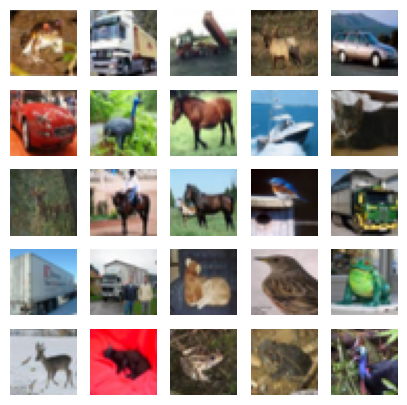

In [ ]:
# Code to load 25 cifar10 images
# load cifar10 images
(images, _), (_, _) = cifar10.load_data()
print('Success')
# Select a subset of 25 images
images = images[:25]
fig=plt.figure(figsize=(5, 5))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.show()

Add some noise to these images for calculating FID

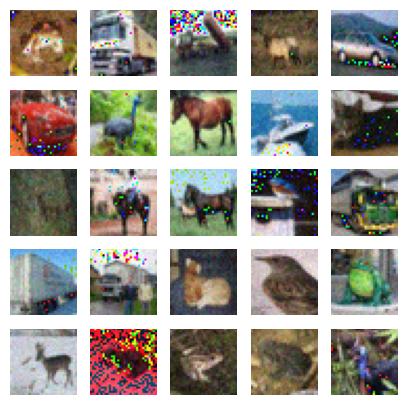

In [ ]:
noisy_images = images.copy()
for i in range(len(images)):
  noisy_images[i] = images[i] + np.random.normal(0, 10, (32,32,3))
fig=plt.figure(figsize=(5, 5))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = noisy_images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.show()

### Auxiliary functions
Below we have two auxiliary functions:


1.   `scale_images(images, new_shape)` takes an array of images and resizes it to a new size
2.  `get_InceptionV3_output(images, prob)` takes an array of images and returns the output after passing them through InceptionV3. Note that *IS* and *FID* take different parts of InceptionV3 output. *IS* takes the output probabilities `(N, 1000)` while *FID* takes the pre-final features `(N, 2048)`. The argument `prob` specifies what kind of output is needed.




In [ ]:
# Auxilliary function to scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.array(images_list)

In [ ]:
def get_InceptionV3_output(images, prob = True):
  """
  A function to get the InceptionV3 output of an array of images.

  Parameters:
  ===========

  images: np.array (N, 32, 32, 3)
      array of input images

  prob: boolean
      if True return output probabilities (N, 1000)
      else return output features (without top layer) (N, 2048)
  """
  N = images.shape[0]
  if prob:
    model = InceptionV3(include_top = True)
  else:
    model = InceptionV3(include_top = False, pooling='avg')
  # scale images to the required size
  images = scale_images(images, (299,299,3))
  # pre-process images, scale to [-1,1]
  images = preprocess_input(images)
  # predict p(y|x)
  output = model.predict(images)

  if prob:
    assert(output.shape == (N, 1000))
  else:
    assert(output.shape == (N, 2048))
  return output

Calculate the inception score on these images

In [ ]:
p_yx = get_InceptionV3_output(images, prob = True)
print(calculate_IS(p_yx))

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
5.815529


Calculate the FID on these images

In [ ]:
act1 = get_InceptionV3_output(images, prob = False)
act2 = get_InceptionV3_output(noisy_images, prob=False)
print(calculate_FID(act1, act2))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
274.30968073200245


### BONUS:
Try to change the amount of noise and see how the FID correlates